# Seasonal feature importance
We will compute feature importance scores for all the features (including HA1 sites as well as metadata features) in the optimized RF model. To compute these scores, the RF model was trained on subsets of training data from 2003NH to x (x ranges from 2014NH to 2020SH).

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import utilities   # self defined functions
import model_utilities   # self defined models
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder

# (for reproduciblility) fix the randomly generated numbers
SEED = 100
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = 'AZAE970101'   # mutation matrix
test_season   = '2014SH'

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',
                 'serumPassCat'
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'optimized_RF'   # the type of model to be used

top_sites_max = 20   # number of inferred top antigenic sites in a season

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/Fig4ab_seasonal_feature_importance/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn         = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
importance_fn   = path_result + "rf_feature_importance_train_2003NH_2014NH.csv"   # feature importance scores for a season
seasonal_imp_fn = path_result + f"Fig4b_seasonal_feature_importance_top_{top_sites_max}_sites.csv"   # seasonal feature importance scores of top antigenic sites
epitope_fn      = path_result + f"Fig4a_epitopes_seasonal_top_{top_sites_max}_sites.csv"   # epitope labels for top antigenic sites
fig_fn          = path_result + f"Fig4b_seasonal_feature_importance_top_{top_sites_max}_sites.svg"   # to save figure
p_values_fn     = path_result + f"Fig4a_epitopes_seasonal_top_{top_sites_max}_sites_p_values.txt"   # to save P values

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [ ]:
data = pd.read_csv(data_fn, converters={'seq_diff': literal_eval})

## Train the model and compute feature importance scores
- For a test season
    - Split the data into training and test datasets. Test dataset will not be used.
    - Prepare encoded inputs (genetic difference and metadata features)
    - Train the model
    - Compute and save feature importance scores

In [ ]:
print("Test Season: ", test_season)

'''
Train Test Split
    - based on seasonal framework
    - Train: past virus isolates paired with past sera
    - Test: circulating virus isolates paired with past sera
'''
ind_train, _ = utilities.seasonal_trainTestSplit(data.copy(), test_season)

# training dataset
data_train = data.iloc[ind_train].copy()
data_train.reset_index(drop=True, inplace=True)


'''
Input features (genetic difference)
'''
# training dataset
X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                       index=data_train.index,
                       columns=HA1_features)
X_train.fillna(0, inplace=True)   # replace nan with 0


'''
Input features (metadata features)
'''
X_train_meta = data_train[meta_features].fillna('None').astype('str')
X_test_meta  = data_test[meta_features].fillna('None').astype('str')


# one hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_meta = ohe.fit_transform(X_train_meta).toarray()

X_train = np.hstack((X_train.values, X_train_meta))


del X_train_meta


'''
Training
'''
# optimized model
model = getattr(model_utilities, f'model_{model_name}')
results = model(X_train,
                data_train.nht.values,
                X_test = X_train) # X_test is just passed to ignore argument error and it will not be used


'''
Compute feature importance scores
'''
importances = results['model'].feature_importances_

# save as a dataframe
feature_importance = pd.DataFrame(columns={"feature", "importance"})
feature_importance["feature"]    = HA1_features + cat_feature_names
feature_importance["importance"] = importances
feature_importance.sort_values(["importance"], ascending=False, inplace=True)
feature_importance.to_csv(importance_fn, index=False)

print("Saved to filename: ", importance_fn)

## Repeat computation of feature importance
Repeat the computation of feature importance scores for seasons from 2014NH to 2020SH.

For this, repeat the code cells first under heading "Variables", "Paths and filenames" and then "Train the model and compute feature importance scores" for following values of the variable "test_season", and filename "importance_fn":
- **test_season**='2015NH', **importance_fn**=path_result + "rf_feature_importance_train_2003NH_2014SH.csv"
- **test_season**='2015SH', **importance_fn**=path_result + "rf_feature_importance_train_2003NH_2015NH.csv"

up to

- **test_season**='2021NH', **importance_fn**=path_result + "rf_feature_importance_train_2003NH_2020SH.csv"

## Compile feature importance scores for top antigenic sites
- Merge seasonal importance scores from 2014NH to 2020SH
- For the provided number of top sites per season, compile corresponding feature importance scores and epitope labels

In [ ]:
'''
merge seasonal importance scores
'''
end_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]

sites    = ["HA1_"+str(site) for site in range(1,330)]
ag_sites = pd.DataFrame()
ag_sites["feature"] = sites

for end_season in end_Seasons:
    df = pd.read_csv(f"rf_feature_importance_train_2003NH_{end_season}.csv")
    df = df[df.feature.str.contains("HA1")]
    df.rename(columns={"importance": f"{end_season}"}, inplace=True)
    ag_sites = ag_sites.merge(df, how="inner", on="feature")

ag_sites.rename(columns={"feature":"site"}, inplace=True)


'''
top sites for each season
'''
top_sites = pd.DataFrame()

# for end season 2014NH
ag_sites.sort_values(["2014NH"], ascending=False, inplace=True)
ag_sites.reset_index(drop=True, inplace=True)
top_sites = ag_sites.loc[0:top_sites_max-1, ["site", "2014NH"]].copy()

# for end season from 2014SH to 2020SH
for end_season in end_Seasons[1:]:
    ag_sites.sort_values([f"{end_season}"], ascending=False,  inplace=True)
    ag_sites.reset_index(drop=True, inplace=True)
    df = ag_sites.loc[0:top_sites_max-1, ["site", f"{end_season}"]].copy()
    top_sites = top_sites.merge(df, how="outer", on="site")

# remove HA1 tag and use number as int
HA1_site_numbers = top_sites.site.str.split("_", expand=True)[1].astype(int)
top_sites.insert(loc=0, column='HA1_site', value=HA1_site_numbers)


'''
Merge epitope labels
'''
# get epitope sites
ep_sites_bush = get_ep_sites(epDef="Bush")

top_sites = top_sites.merge(ep_sites_bush, how="left", on="site")
top_sites.sort_values(["epitope", "HA1_site"], inplace=True)
top_sites["HA1_site"] = top_sites.HA1_site.astype(str)

top_sites_epitopes = top_sites[["site", "HA1_site", "epitope"]]
top_sites.drop(columns={"site", "epitope"}, inplace=True)

top_sites.to_csv(seasonal_imp_fn, index=False)
top_sites_epitopes.to_csv(epitope_fn, index=False)

## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read and prepare data for plots

In [5]:
top_sites = pd.read_csv(seasonal_imp_fn)
top_sites = top_sites.set_index("HA1_site")

## Plot inferred top antigenic sites and their corresponding feature importance scores per season

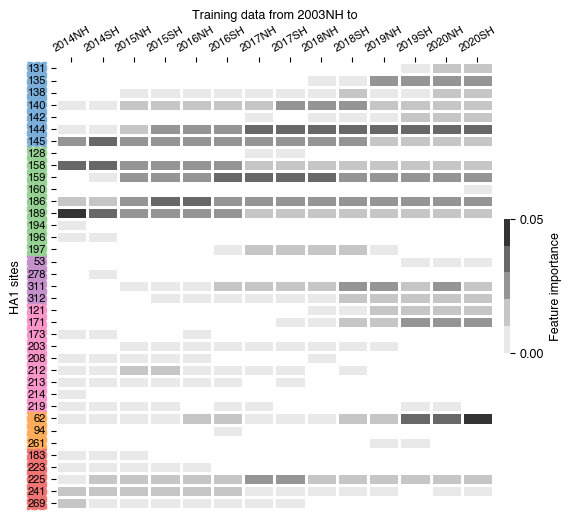

In [7]:
fig, ax = plt.subplots(figsize=(6.8,5.8))

tmp = sns.heatmap(top_sites,
                  # annot=True, annot_kws={"size":8}, fmt='.3f',
                  vmin=0.0,
                  vmax=0.05,
                  cmap=sns.color_palette("Greys", 5),
                  cbar_kws={"shrink":0.3,
                            "orientation":"vertical",
                            "label":"Feature importance",
                            "pad":0.02},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# configurations for figure
cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=9)
cbar.ax.yaxis.label.set_size(9)
cbar.ax.set_yticks([cbar.ax.get_yticks()[0], cbar.ax.get_yticks()[-1]])

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

ax.set_xlabel("Training data from 2003NH to", fontsize=9)
ax.set_ylabel("HA1 sites", fontsize=9)


# colors for epitopes
Colors = [(122/255, 173/255, 216/255),
          (150/255, 209/255, 147/255),
          (196/255, 145/255, 203/255),
          (248/255, 150/255, 201/255),
          (255/255, 173/255, 91/255),
          (239/255, 117/255, 117/255)]


# patches for epitope A, B, C, D, E, and unknown
x_pos = -0.91
x_len = 0.6
Y_pos = [-0.05, 7, 16, 20, 29, 32]
Y_len = [7, 9, 4, 9, 3, 5]
for y_pos, y_len, color in zip(Y_pos, Y_len, Colors):
    ax.add_patch(plt.Rectangle((x_pos, y_pos), x_len, y_len, ls="--", ec=color, fc=color,
                                # alpha=color_fade,
                               clip_on=False))


# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')

## Compute statistical significance of top antigenic sites as per Bush epitope definitions

In [5]:
# imports
from math import comb

# read epitope information of top sites
top_sites_epitopes = pd.read_csv(epitope_fn)


'''
Compute statistical significance
'''
n  = top_sites_epitopes.shape[0]     # total number of top sites
Js = [19, 22, 27, 41, 22]   # number of epitope sites
Is = top_sites_epitopes.epitope.value_counts().sort_index().values   # number of top sites in each epitope

P_values = []

# for each epitope
for i, j in zip(Is, Js):
    p_value = 0
    
    # compute p-value
    for q in range(i, min([j, n])):
        p_value += (comb(j,q) * comb(329-j, n-q))/comb(329,n)
    
    # save p-value for each epitope
    P_values.append(p_value)


# save P values
with open(p_values_fn, 'a') as fh:
    fh.write(f"epitope A: {P_values[0]}\n")
    fh.write(f"epitope B: {P_values[1]}\n")
    fh.write(f"epitope C: {P_values[2]}\n")
    fh.write(f"epitope D: {P_values[3]}\n")
    fh.write(f"epitope E: {P_values[4]}\n")